In [1]:
#Shengchao, Juan 
#Apr.2021
#v1.1
#
#Edited by Aidan, added multiple iterations
#Jun.2021
#July 15, new version, Juan, adding multiple iterations in multiple channels, cleaning the code


import numpy as np
import pandas as pd
import scipy
import scipy.stats
import scipy.optimize as op
from scipy.optimize import curve_fit
import os
from scipy.integrate import quad 
import datetime

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
#from multihist import Histdd


import time
import sys
import tqdm

import math
import random
import numba

from scipy.stats import norm

import struct

In [2]:
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

In [46]:
len(data_raw[11_161_000:-1_945_000:2])

800

In [333]:
#read file for multiple channels
channels=8
dmafiforeq=16384 #requested number of elements of the dma fifo in the PC code, set to 2xDMA FIFO depth
iterations=1000 #number of iterations of the PC code
fileName = '/project/darkmatters/WINDCHIME/Protochime_data/16chan2.dat'
data_raw = numpy.fromfile(fileName, dtype="<i2").tolist() #> for big endian, < for little, i2 for signed integer of 2 bytes=16 bits
print("binary file received after deleting headers is size "+str(len(data_raw)-4*iterations))

KeyboardInterrupt: 

In [ ]:
if len(data_raw)!=(dmafiforeq*channels+4)*iterations:
    print('expected {} and received {} data do not match'.format(len(data_raw),(dmafiforeq*channels+4)*iterations))
#deleting headers: there is a 4 entry header {channels,0,dmafiforeq,0} at the beginning of every subarray in labview, which has dmafiforeq*channels columns
#also, it goes in reverse so it doesnt change the header indexes to be deleted, if it wasnt reversed, the index n would be the
#index n-4 after 1 complete iteration of the cycle
for i in reversed(range(iterations)):
    if data_raw[i*(channels*dmafiforeq+4)+3]==0 and data_raw[i*(channels*dmafiforeq+4)+2]==dmafiforeq and data_raw[i*(channels*dmafiforeq+4)+1]==0 and data_raw[i*(channels*dmafiforeq+4)]==channels:
        data_raw.pop(i*(channels*dmafiforeq+4)+3)
        data_raw.pop(i*(channels*dmafiforeq+4)+2)
        data_raw.pop(i*(channels*dmafiforeq+4)+1)
        data_raw.pop(i*(channels*dmafiforeq+4))
    else:
        print('Warning: elements to be deleted in iteration {} are not headers'.format(i))
    if i%20==0:
        print('{} iterations remaining'.format(i))
        
#double checking
if len(data_raw)%iterations!=0:
    print('warning: each iteration does not have the correct requested number of elements')

if iterations*channels*dmafiforeq==len(data_raw):
    print('the total number of elements {} is as expected'.format(len(data_raw)))
    print('Done!')

In [ ]:
#Creating two iteration matrixes, one for channels A1...A7, one for channels B8...B1
iter_matrix_A=np.array(data_raw[::2])
iter_matrix_B=np.array(data_raw[1::2])

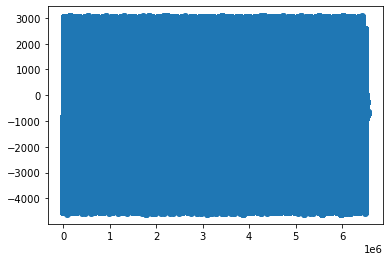

In [202]:
plt.plot(iter_matrix_B,linestyle='None',marker='o')
#plt.plot(iter_matrix_A[1000000:],linestyle='None',marker='o')
plt.show()

In [236]:
#plt.plot(data_raw,linestyle='None',marker='o')
#plt.plot(iter_matrix_B,linestyle='None',marker='o')
#plt.plot(iter_matrix_A[0:20000],linestyle='None',marker='o')
#plt.show()

if iter_matrix_A.shape[0]!=iter_matrix_A.shape[0]:
    print('array A and B are not of the same size')
if iter_matrix_A.shape[0]+iter_matrix_A.shape[0]!=len(data_raw):
    print('elements of A + B does not equal total number of elements')

In [ ]:
#B goes from 0 to 7, A from 8 to 15
dmafiforeq_red=int(dmafiforeq/2)
iter_matrix=np.reshape(iter_matrix_A,(iterations,int(iter_matrix_A.shape[0]/iterations)))


#creating one array per channel: first iterations*dmafiforeq elements in each row corresponds to channel x, x from 0 to channels


temp0=np.reshape(iter_matrix[:,0:dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp1=np.reshape(iter_matrix[:,dmafiforeq_red:2*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp2=np.reshape(iter_matrix[:,2*dmafiforeq_red:3*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp3=np.reshape(iter_matrix[:,3*dmafiforeq_red:4*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp4=np.reshape(iter_matrix[:,4*dmafiforeq_red:5*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp5=np.reshape(iter_matrix[:,5*dmafiforeq_red:6*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp6=np.reshape(iter_matrix[:,6*dmafiforeq_red:7*dmafiforeq_red],(1,dmafiforeq_red*iterations))
temp7=np.reshape(iter_matrix[:,7*dmafiforeq_red:8*dmafiforeq_red],(1,dmafiforeq_red*iterations))


channels=np.transpose(np.array([temp0[0],temp1[0],temp2[0],temp3[0],temp4[0],temp5[0],temp6[0],temp7[0]])) #1 channel per column
print(np.shape(channels))

data=pd.DataFrame(channels, columns=None) #channel 1 is labeled as 0, channel n is labeled as n-1

In [ ]:
sample_freq = 1.25  #MHz
data['time_ms']= 1e-3/sample_freq*data.index #ms

In [332]:
"""np.save('noise_1000iter_chan5',data[5])
np.save('noise_1000iter_chan6',data[6])
np.save('noise_1000iter_chan7',data[7])
"""

"""
np.save('noise_1000iter_chan8',data[0])
np.save('noise_1000iter_chan9',data[1])
np.save('noise_1000iter_chan10',data[2])
np.save('noise_1000iter_chan11',data[3])
np.save('noise_1000iter_chan12',data[4])
np.save('noise_1000iter_chan13',data[5])
np.save('noise_1000iter_chan14',data[6])
np.save('noise_1000iter_chan15',data[7])
"""

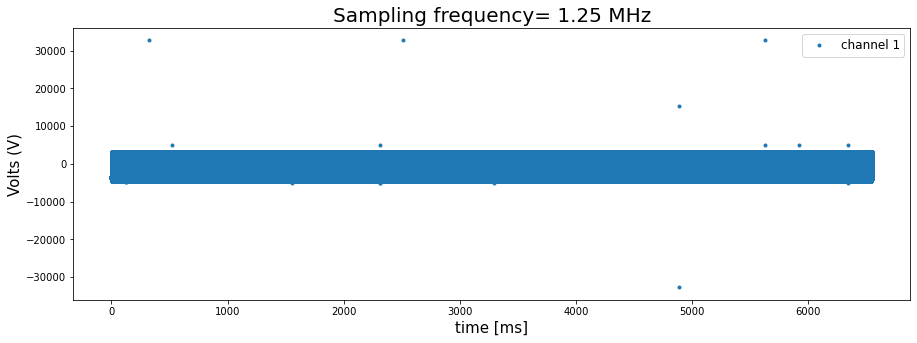

In [323]:
start=len(data[0])-60000
end=len(data[0])
#print(data[0][start:end])
plt.figure(figsize=(15,5))
plt.title("Sampling frequency= "+str(sample_freq)+" MHz",size=20)

plt.plot(data['time_ms'][start:end],data[0][start:end],label='channel 1',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[1],label='channel 2',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[2],label='channel 3',marker='.',linestyle='none')
#plt.plot(data['time_us'],data[3],label='channel 4',marker='.',linestyle='none')

plt.ylabel('Volts (V)',size=15)
plt.xlabel('time [ms]',size=15)

#fit_result= fit_sin(data['time_ms'],data[0])
#sin_func=fit_result['fitfunc']

#plt.plot(data['time_ms'][start:end],sin_func(data['time_ms'][start:end]), label='fitted frequency and Amplitude=%.3f kHz, %.3f V'%(fit_result['freq']*1000,fit_result['amp']))
plt.legend(fontsize=12, loc='best')
#plt.ylim([-30000,30000])
plt.show()

In [ ]:
#number of peaks found vs expected
start=0
end=len(data[0])
fit_result= fit_sin(data['time_us'][start:end],data[0][start:end])
sin_func=fit_result['fitfunc']
import scipy.signal
peaks=scipy.signal.find_peaks(sin_func(data['time_us'][start:end]))
number_found=len(peaks[0])
#print(peaks,number_found)

In [ ]:
input_freq=30101.5 #Hz or cycles per sec
sampling_points=np.shape(channels)[0] #per channel
sampling_freq=2500000#clock rate in LabView FPGA
number_expected=sampling_points*input_freq/sampling_freq
print(number_expected)
cycles_lost=abs(number_expected-number_found)
print(cycles_lost)

In [ ]:
#points lost in the acquiring process: each cycle takes 1/freq seconds to happen, and we take sampling_rate data points per second
points_lost=cycles_lost*sampling_freq/input_freq
print(points_lost)

In [ ]:
#first peak
first_pk=peaks[0][0]
last_pk=peaks[0][-1]
points_between=last_pk-first_pk


In [ ]:
plt.hist(x = data[0][100000:], bins = 100, log = True)

In [ ]:
a = [1,2,3,2]
for f in a:
    print(a.index(f))

In [ ]:
print(2**13)